In [22]:
from skimage import io
import dlib
import glob

import numpy as np
from scipy import ndimage

from PIL import Image # 画像表示用
import matplotlib.pyplot as plt # 画像表示用
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./data/shape_predictor_68_face_landmarks.dat")

def procrustes(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy.

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        matrices of target and input coordinates. they must have equal
        numbers of  points (rows), but Y may have fewer dimensions
        (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(0)
    muY = Y.mean(0)

    X0 = X - muX
    Y0 = Y - muY

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    T = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(T) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            T = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = normX*traceTA*np.dot(Y0, T) + muX

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = normY*np.dot(Y0, T) + muX

    # transformation matrix
    if my < m:
        T = T[:my,:]
    c = muX - b*np.dot(muY, T)

    #transformation values 
    tform = {'rotation':T, 'scale':b, 'translation':c}

    return d, Z, tform

In [23]:
f = "./data/base_face.jpg"
img = io.imread(f)
dets = detector(img, 1)
for k, d in enumerate(dets):
    shape = predictor(img, d).parts()
    shape_base = np.moveaxis(np.array([[point.x for point in shape], [point.y for point in shape]], dtype=float), 1, 0)

In [88]:
def transform(img):
    imgt = ndimage.affine_transform(img, tform['rotation'].T)
    imgt = ndimage.zoom(imgt, tform['scale'])
    imgt = ndimage.shift(imgt, reversed(tform['translation']))
    return imgt[0:229, 0:229]
#     return imgt

Processing file: ./dlib_data/0092e416edbceb4f0171a58fc2e1c6e5a3565027.jpg


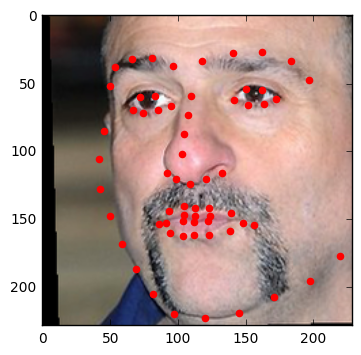

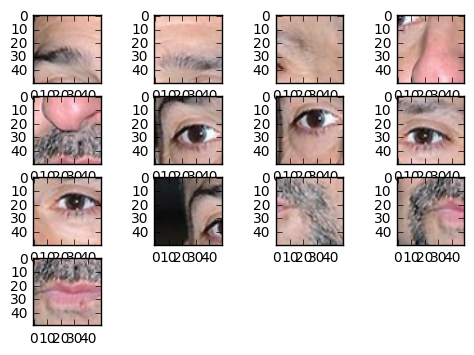

Processing file: ./dlib_data/0d2e5f41a8adfd3505320bbeb6a0ce0d2a6d7267.jpg


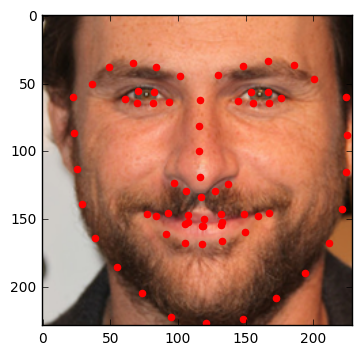

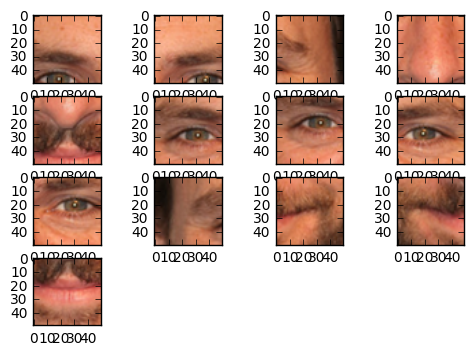

Processing file: ./dlib_data/059e2ef3a42a6a00a0c26e23fee2373f60e2e850.jpg


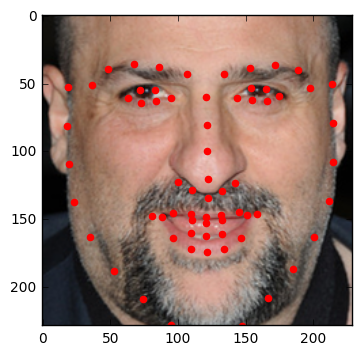

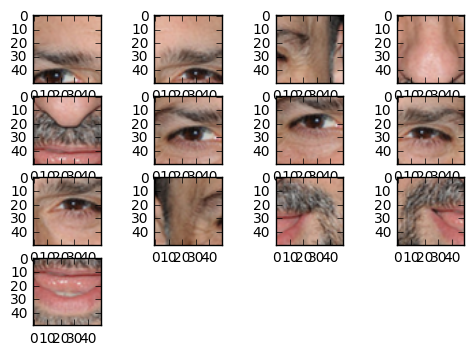

In [89]:
points = [20, 23, 26, 29, 33, 37, 41, 44, 47, 17, 54, 60, 66]
for f in glob.glob("./dlib_data/*.jpg"):
    print("Processing file: {}".format(f))
    img = io.imread(f)
    
    dets = detector(img, 1)
    for  k, d in enumerate(dets):
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d).parts()
        shape = np.moveaxis(np.array([[point.x for point in shape], [point.y for point in shape]], dtype=float), 1, 0)
    d, z, tform = procrustes(shape_base, shape, scaling=True, reflection='best')
    v = shape_base.T
    w = z.T
#     plt.scatter(v[0], v[1])
    plt.scatter(w[0], w[1], color='red')
    imgt = np.squeeze(np.dsplit(img, 3))
    imgt = map(transform, imgt)
    imgt = np.moveaxis(imgt, 0, -1)
#     print(np.shape(imgt))
    plt.imshow(imgt)
    plt.show()
#     print(tform)
    fig = plt.figure()
    i=1
    zz = z.astype(int)
    for p in points:
        fig.add_subplot(4, 4, i)
        i+=1
        imgtt = imgt[zz[p][1]-25:zz[p][1]+25, zz[p][0]-25:zz[p][0]+25, :]
        plt.imshow(imgtt)
    
    plt.show()
        
    